In [1]:
pip install torch torchvision transformers kagglehub scikit-learn matplotlib seaborn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [2]:
import os
import kagglehub

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTConfig, get_scheduler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from PIL import Image


# Prepare Data

In [3]:
# download data from kaggle
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")
print("Path to dataset files:", path)

# path
data_dir = os.path.join(path, "flowers")


100%|██████████| 225M/225M [00:01<00:00, 216MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2


In [34]:
import torchvision.transforms as transforms

IMG_SIZE = 224
BATCH_SIZE = 32

# train transform
train_transform = transforms.Compose([
    # Resized
    transforms.RandomResizedCrop(IMG_SIZE),
    # HorizontalFlip
    transforms.RandomHorizontalFlip(),
    # RandomRotation
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# val transform（just Resize + normalize）
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [35]:
from torchvision import datasets
from torch.utils.data import Subset

full_dataset = datasets.ImageFolder(root=data_dir, transform=None)
class_names = full_dataset.classes
num_classes = len(class_names)
print("class_names:", class_names)

# split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

# prepossing
train_dataset =Subset(
    dataset=datasets.ImageFolder(root=data_dir, transform=train_transform),
    indices=train_subset.indices
)
val_dataset = Subset(
    dataset=datasets.ImageFolder(root=data_dir, transform=val_transform),
    indices=val_subset.indices
)

print(f"train size: {len(train_dataset)}")
print(f"val size: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)


class_names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
train size: 3453
val size: 864


In [36]:
batch_x, batch_y = next(iter(train_loader))
print("Batch x shape:", batch_x.shape)   # (32, 3, 224, 224) as expected
print("Batch y shape:", batch_y.shape)   # (32,)




Batch x shape: torch.Size([32, 3, 224, 224])
Batch y shape: torch.Size([32])


# Prepare pertain model

In [15]:
# define pretrain vit model, this one has 12 heads
config = ViTConfig.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=num_classes,
    id2label={i: label for i, label in enumerate(class_names)},
    label2id={label: i for i, label in enumerate(class_names)},
    output_attentions=True
)

# load pretrain model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    config=config,
    ignore_mismatched_sizes=True  # ignore_mismatched_sizes, in our case 5 classes
)

# freeze the model for now
for param in model.vit.parameters():
    param.requires_grad = False

# train only the last layer for classisy
for param in model.classifier.parameters():
    param.requires_grad = True

#
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

print(f"device: {device}")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device: cuda


# Train model

  0%|          | 0/2700 [00:00<?, ?it/s]

Epoch 1/25
loss: 1.0938
val accuracy: 87.15%
classification_report：
              precision    recall  f1-score   support

       daisy       0.84      0.91      0.87       153
   dandelion       0.89      0.97      0.93       205
        rose       0.82      0.73      0.77       163
   sunflower       0.96      0.89      0.92       148
       tulip       0.85      0.85      0.85       195

    accuracy                           0.87       864
   macro avg       0.87      0.87      0.87       864
weighted avg       0.87      0.87      0.87       864



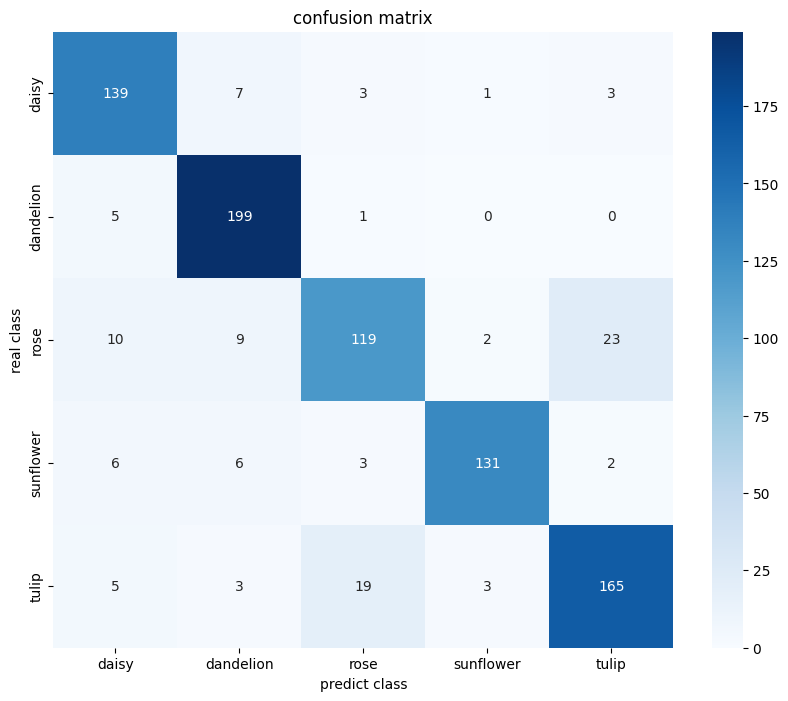

Epoch 2/25
loss: 0.5896
val accuracy: 91.09%
classification_report：
              precision    recall  f1-score   support

       daisy       0.90      0.92      0.91       153
   dandelion       0.95      0.98      0.96       205
        rose       0.84      0.82      0.83       163
   sunflower       0.99      0.93      0.96       148
       tulip       0.88      0.90      0.89       195

    accuracy                           0.91       864
   macro avg       0.91      0.91      0.91       864
weighted avg       0.91      0.91      0.91       864



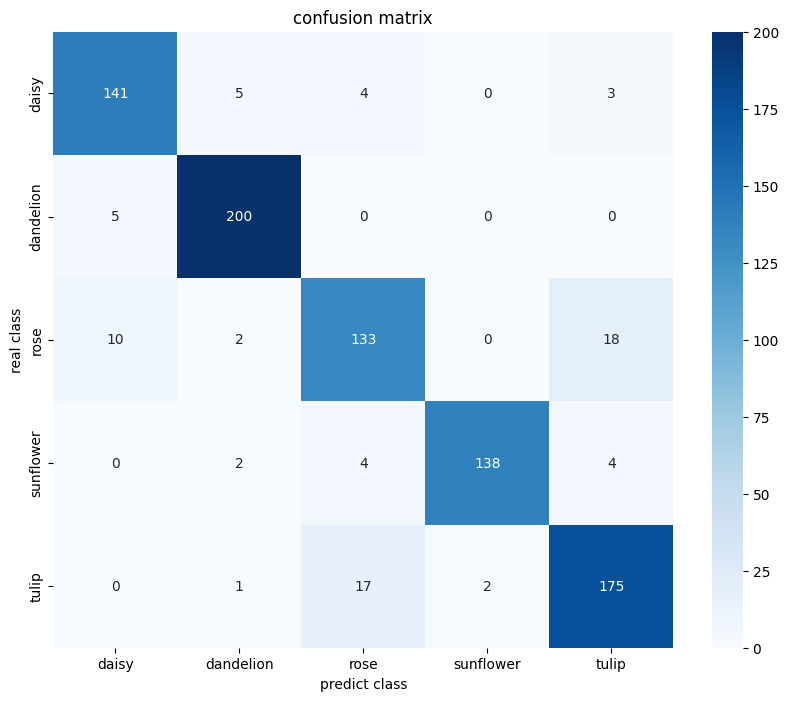

Epoch 3/25
loss: 0.4399
val accuracy: 92.82%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.92      0.93       153
   dandelion       0.94      0.99      0.96       205
        rose       0.86      0.88      0.87       163
   sunflower       0.99      0.95      0.97       148
       tulip       0.92      0.90      0.91       195

    accuracy                           0.93       864
   macro avg       0.93      0.93      0.93       864
weighted avg       0.93      0.93      0.93       864



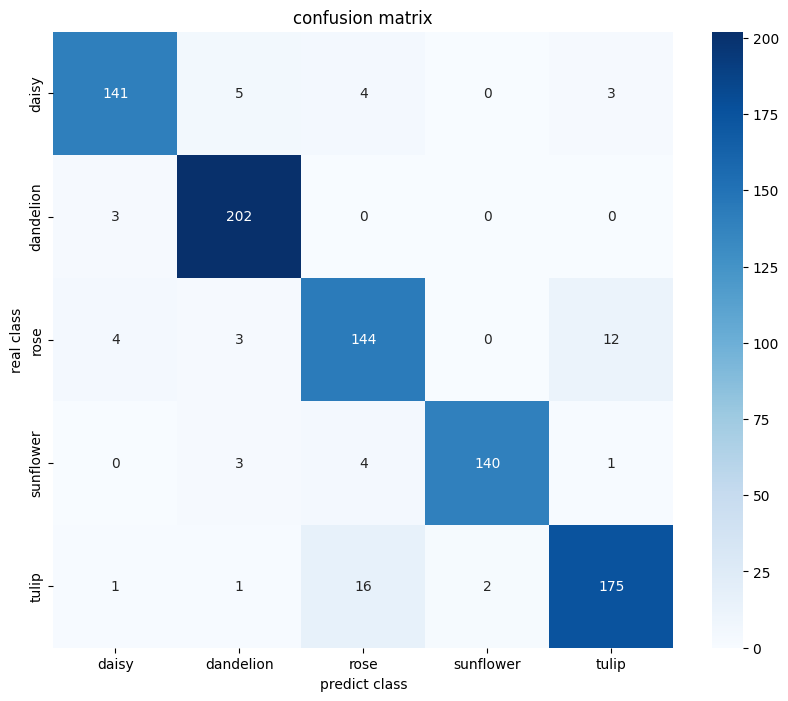

Epoch 4/25
loss: 0.3770
val accuracy: 93.40%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.95      0.98      0.97       205
        rose       0.87      0.90      0.88       163
   sunflower       0.99      0.95      0.97       148
       tulip       0.91      0.91      0.91       195

    accuracy                           0.93       864
   macro avg       0.94      0.93      0.93       864
weighted avg       0.93      0.93      0.93       864



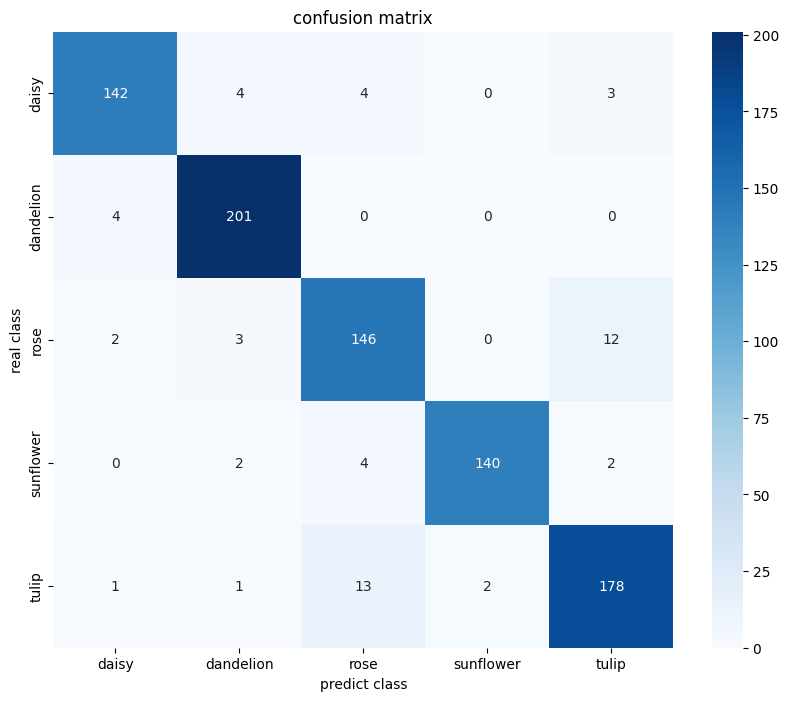

Epoch 5/25
loss: 0.3520
val accuracy: 93.40%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.94      0.98      0.96       205
        rose       0.89      0.88      0.89       163
   sunflower       0.99      0.95      0.97       148
       tulip       0.91      0.92      0.91       195

    accuracy                           0.93       864
   macro avg       0.94      0.93      0.93       864
weighted avg       0.93      0.93      0.93       864



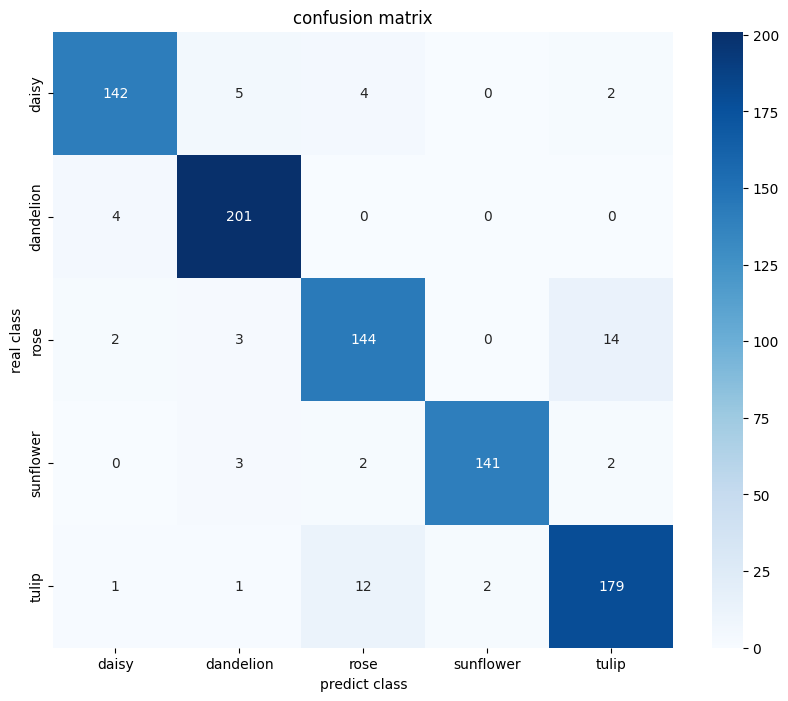

Epoch 6/25
loss: 0.3203
val accuracy: 93.52%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.94      0.98      0.96       205
        rose       0.88      0.90      0.89       163
   sunflower       0.99      0.95      0.97       148
       tulip       0.93      0.91      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.93      0.94       864
weighted avg       0.94      0.94      0.94       864



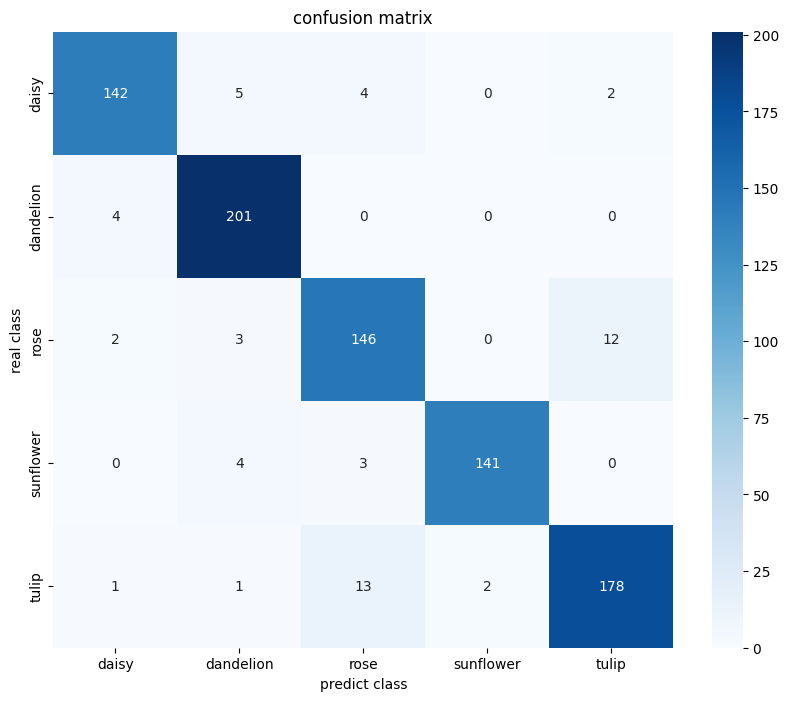

Epoch 7/25
loss: 0.3025
val accuracy: 93.63%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.95      0.98      0.96       205
        rose       0.89      0.88      0.89       163
   sunflower       0.99      0.95      0.97       148
       tulip       0.91      0.92      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.93      0.94       864
weighted avg       0.94      0.94      0.94       864



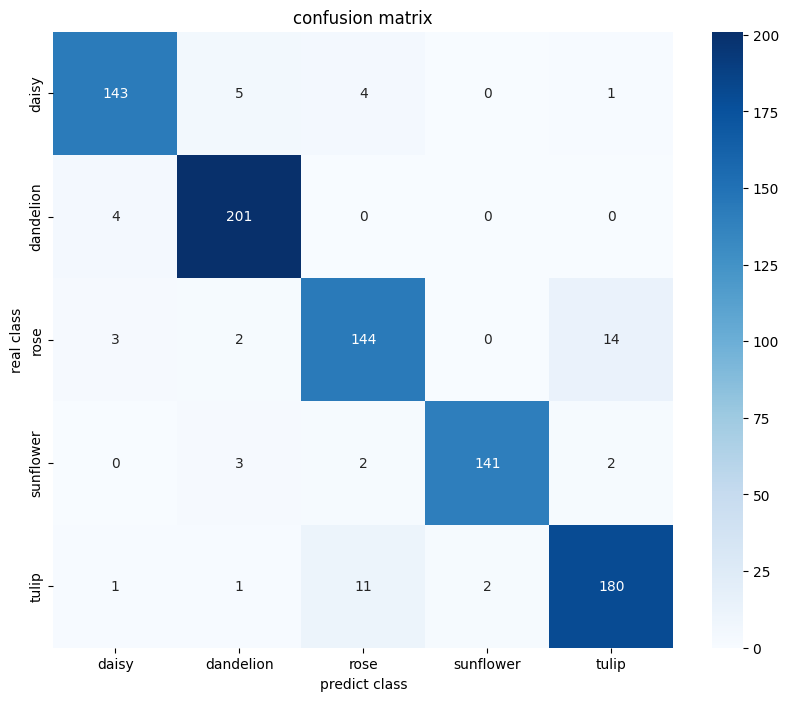

Epoch 8/25
loss: 0.2961
val accuracy: 93.75%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.96      0.98      0.97       205
        rose       0.91      0.88      0.89       163
   sunflower       0.98      0.96      0.97       148
       tulip       0.90      0.92      0.91       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



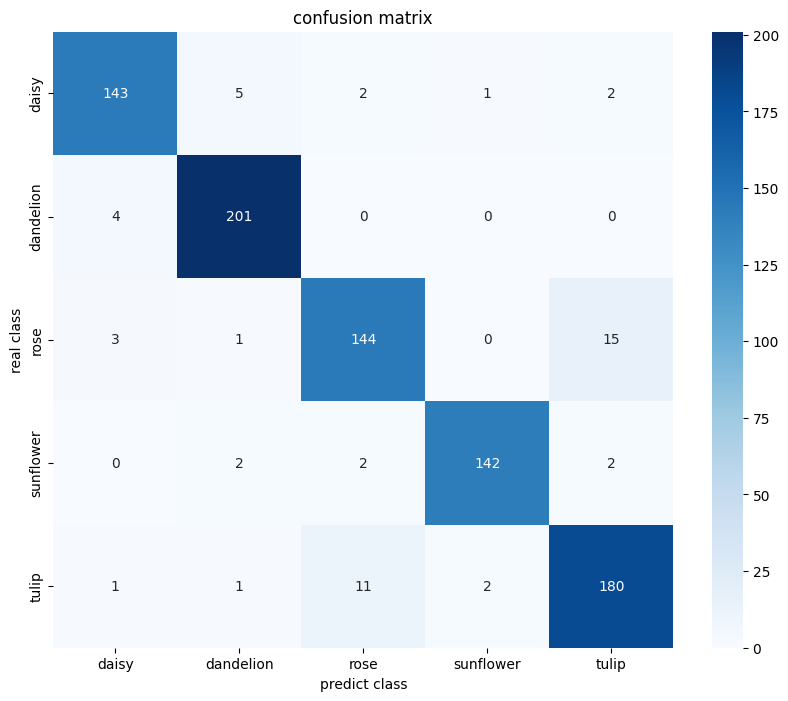

Epoch 9/25
loss: 0.2876
val accuracy: 93.75%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.95      0.98      0.97       205
        rose       0.90      0.90      0.90       163
   sunflower       0.98      0.95      0.96       148
       tulip       0.91      0.92      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



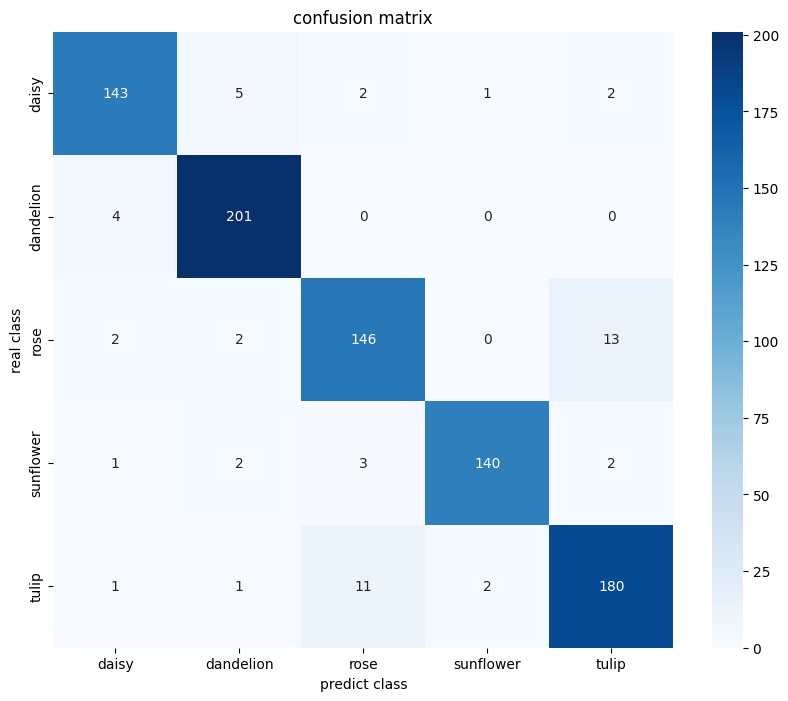

Epoch 10/25
loss: 0.2731
val accuracy: 93.63%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.94      0.98      0.96       205
        rose       0.90      0.90      0.90       163
   sunflower       0.98      0.94      0.96       148
       tulip       0.92      0.92      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.93      0.94       864
weighted avg       0.94      0.94      0.94       864



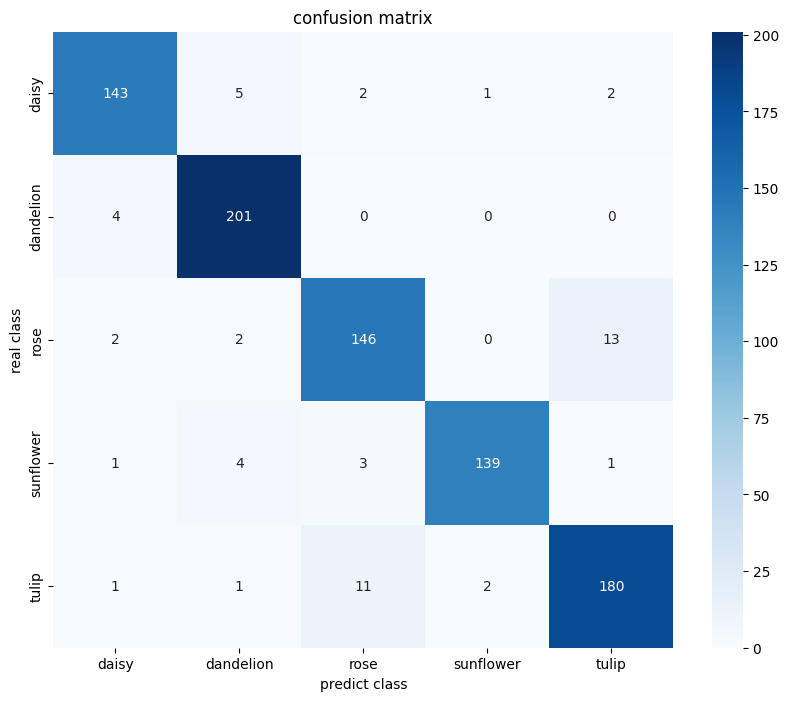

Epoch 11/25
loss: 0.2618
val accuracy: 93.63%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.95      0.98      0.96       205
        rose       0.90      0.90      0.90       163
   sunflower       0.98      0.95      0.96       148
       tulip       0.91      0.92      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.93      0.94       864
weighted avg       0.94      0.94      0.94       864



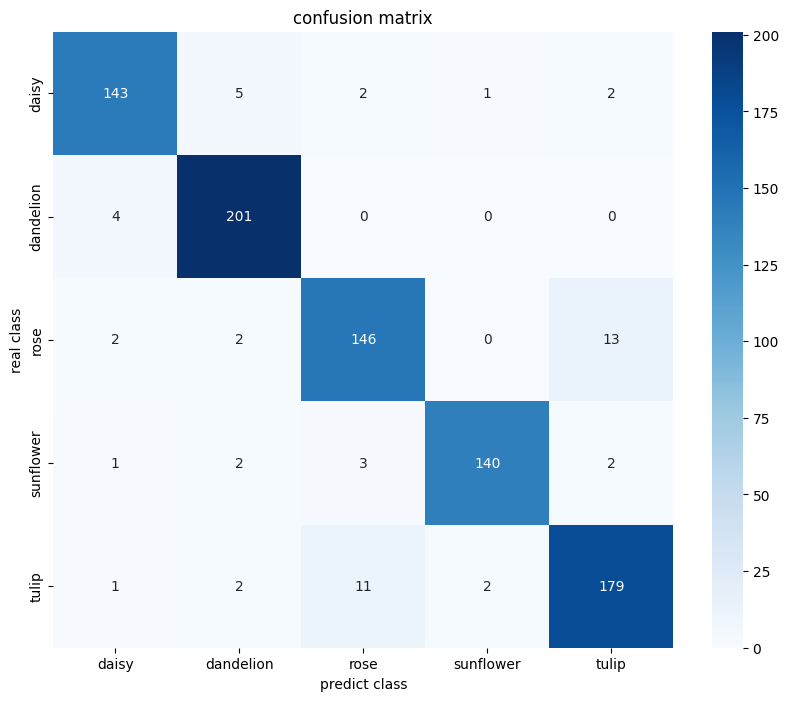

Epoch 12/25
loss: 0.2536
val accuracy: 93.52%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.94      0.98      0.96       205
        rose       0.90      0.89      0.90       163
   sunflower       0.98      0.95      0.96       148
       tulip       0.91      0.92      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.93      0.94       864
weighted avg       0.94      0.94      0.94       864



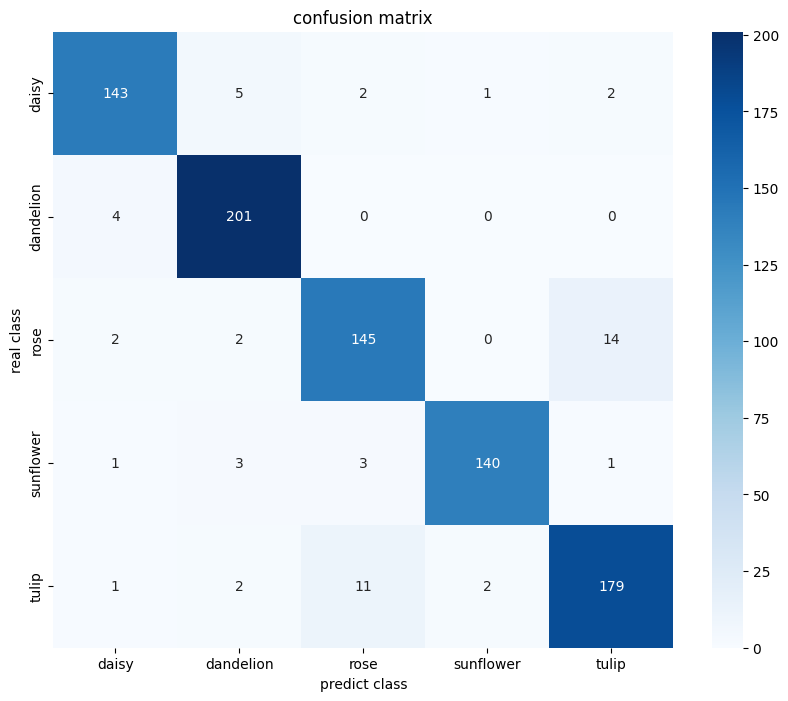

Epoch 13/25
loss: 0.2676
val accuracy: 93.52%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.94      0.98      0.96       205
        rose       0.90      0.89      0.90       163
   sunflower       0.98      0.95      0.96       148
       tulip       0.91      0.92      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.93      0.94       864
weighted avg       0.94      0.94      0.94       864



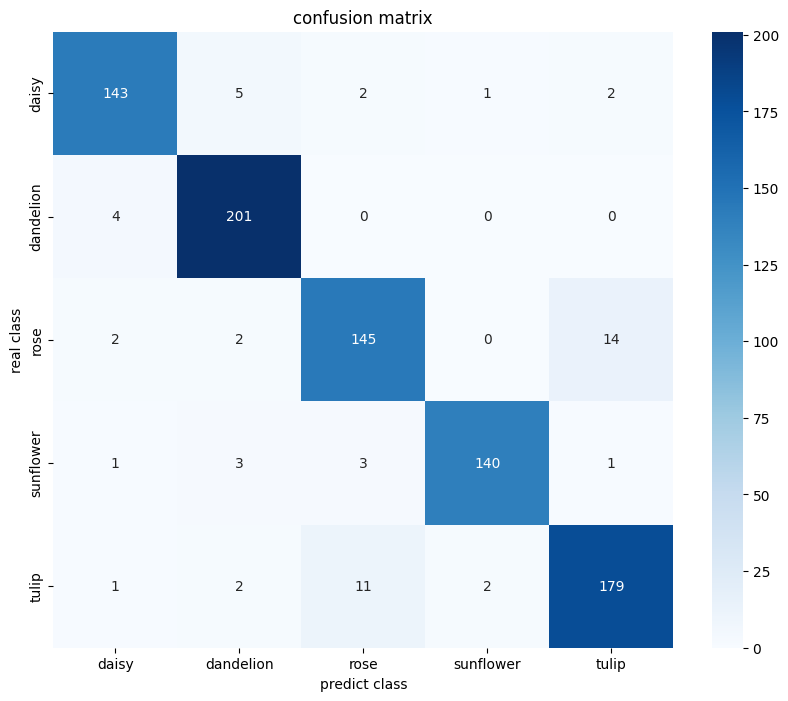

Epoch 14/25
loss: 0.2522
val accuracy: 93.52%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.96      0.98      0.97       205
        rose       0.90      0.89      0.90       163
   sunflower       0.98      0.95      0.96       148
       tulip       0.90      0.92      0.91       195

    accuracy                           0.94       864
   macro avg       0.94      0.93      0.94       864
weighted avg       0.94      0.94      0.94       864



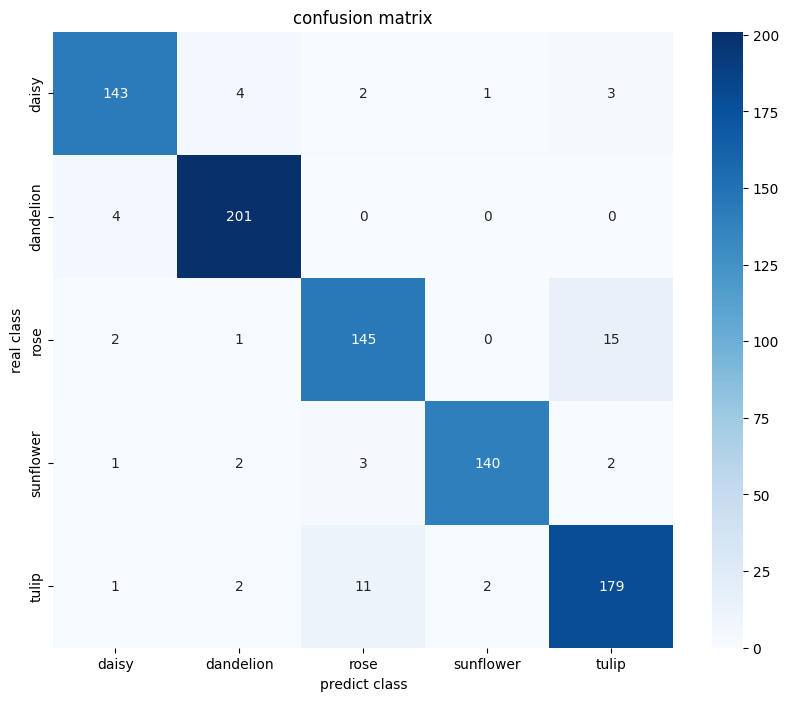

Epoch 15/25
loss: 0.2593
val accuracy: 93.63%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.95      0.98      0.97       205
        rose       0.91      0.89      0.90       163
   sunflower       0.98      0.95      0.97       148
       tulip       0.90      0.92      0.91       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



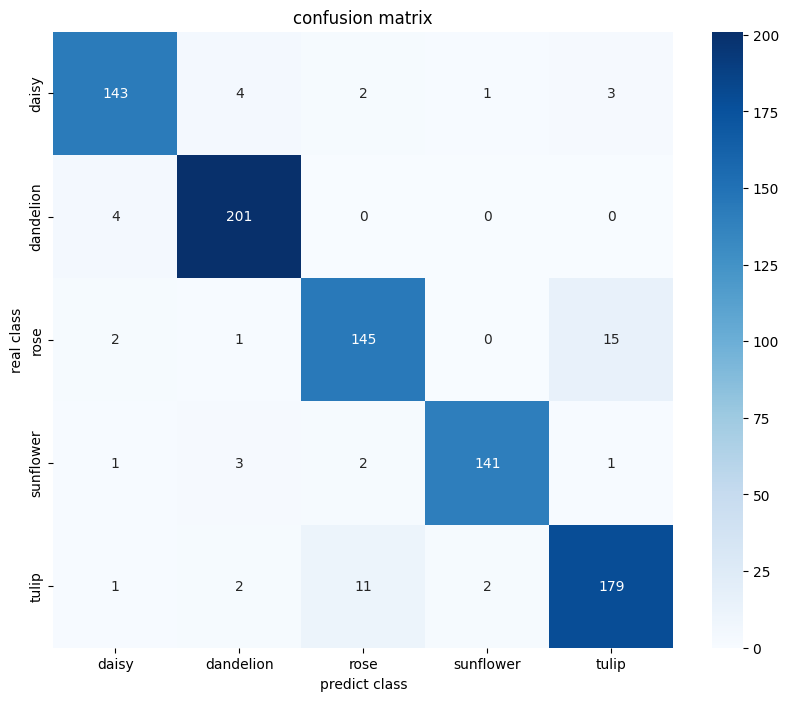

Epoch 16/25
loss: 0.2537
val accuracy: 93.63%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.94      0.98      0.96       205
        rose       0.91      0.89      0.90       163
   sunflower       0.98      0.95      0.97       148
       tulip       0.91      0.92      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



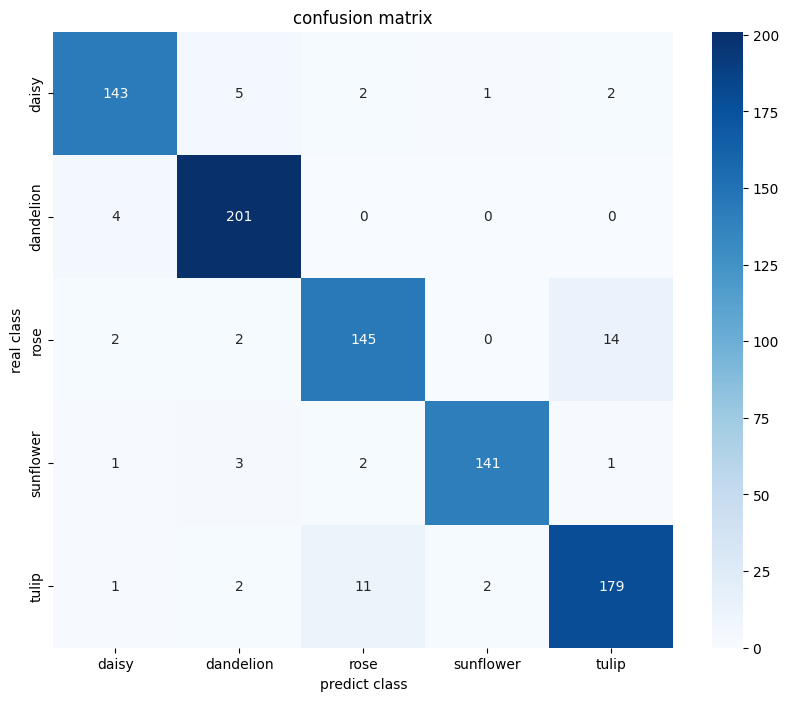

Epoch 17/25
loss: 0.2361
val accuracy: 93.63%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.94      0.98      0.96       205
        rose       0.91      0.89      0.90       163
   sunflower       0.98      0.95      0.97       148
       tulip       0.91      0.92      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



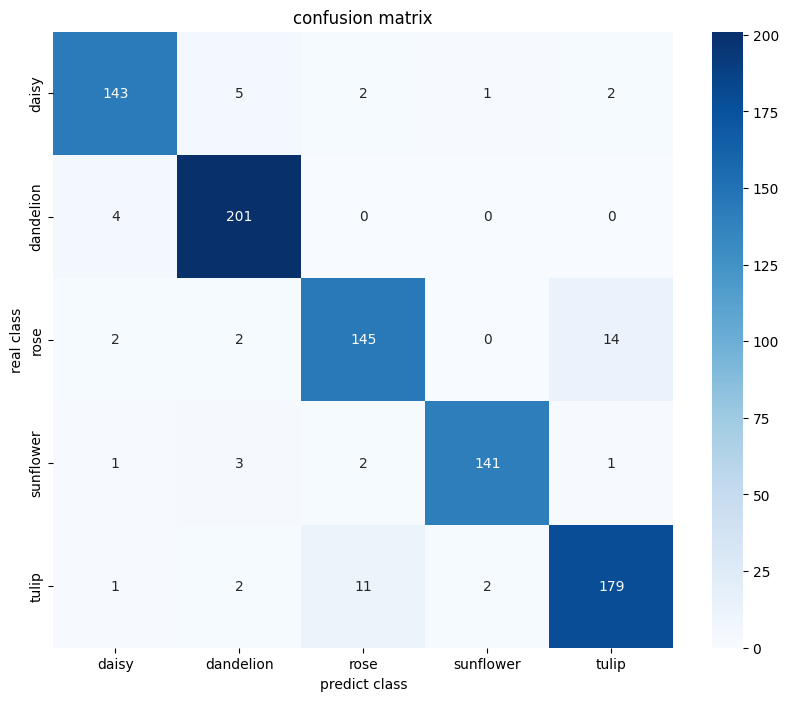

Epoch 18/25
loss: 0.2405
val accuracy: 93.87%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.94      0.98      0.96       205
        rose       0.92      0.89      0.90       163
   sunflower       0.98      0.95      0.97       148
       tulip       0.91      0.93      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



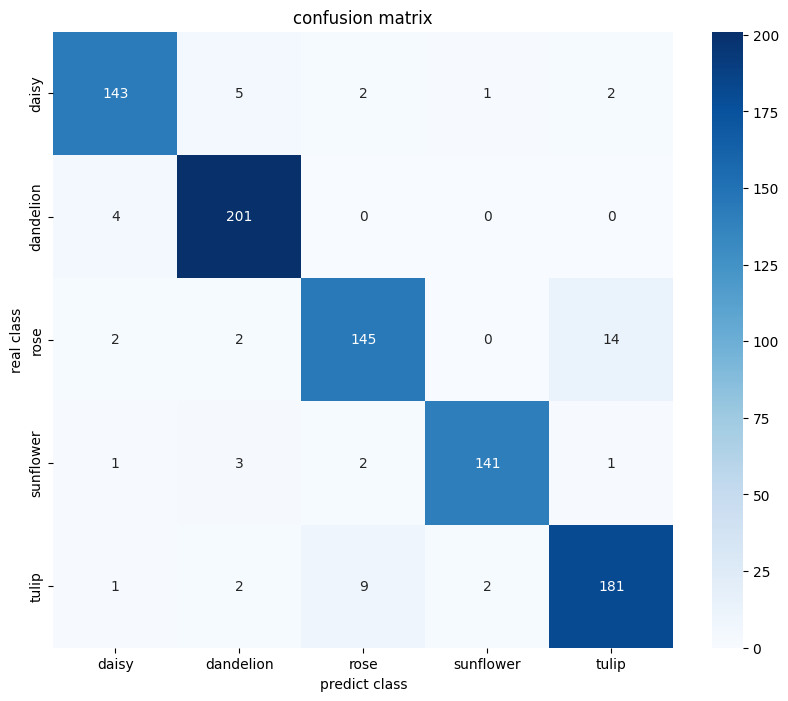

Epoch 19/25
loss: 0.2368
val accuracy: 93.87%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.95      0.98      0.97       205
        rose       0.92      0.89      0.90       163
   sunflower       0.98      0.95      0.97       148
       tulip       0.91      0.93      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



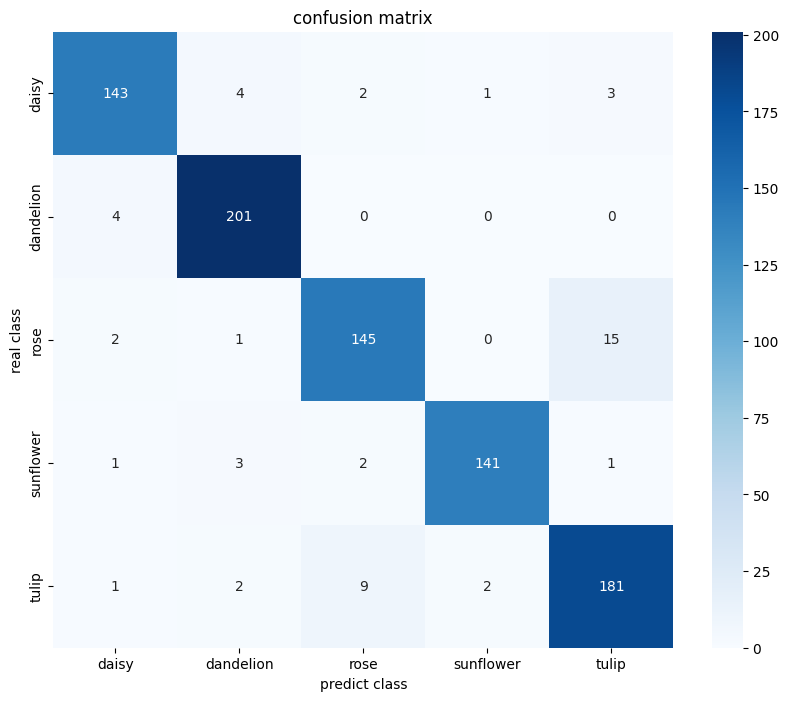

Epoch 20/25
loss: 0.2302
val accuracy: 93.87%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.95      0.98      0.96       205
        rose       0.92      0.89      0.90       163
   sunflower       0.98      0.95      0.97       148
       tulip       0.91      0.93      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



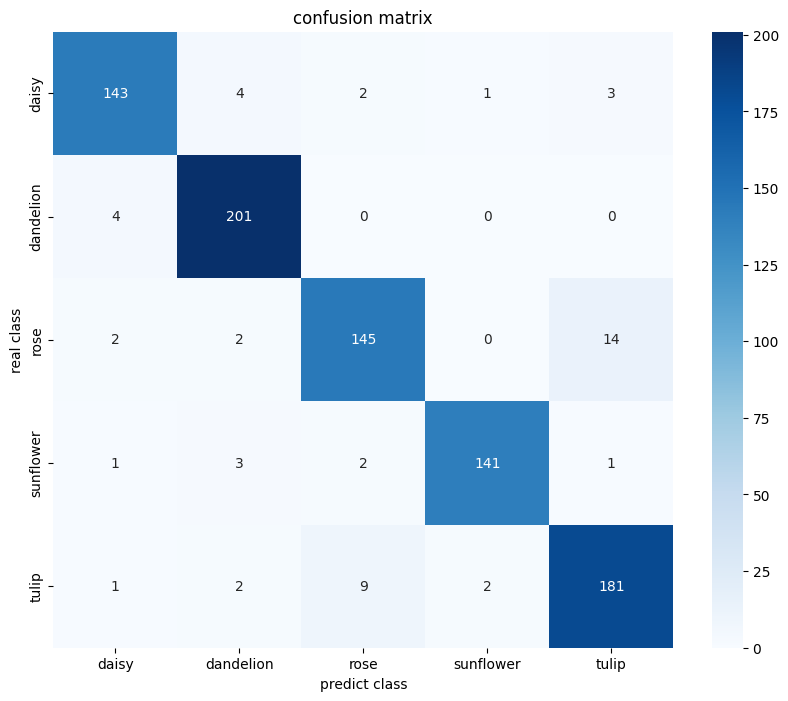

Epoch 21/25
loss: 0.2293
val accuracy: 93.87%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.94      0.98      0.96       205
        rose       0.92      0.89      0.90       163
   sunflower       0.98      0.95      0.97       148
       tulip       0.91      0.93      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



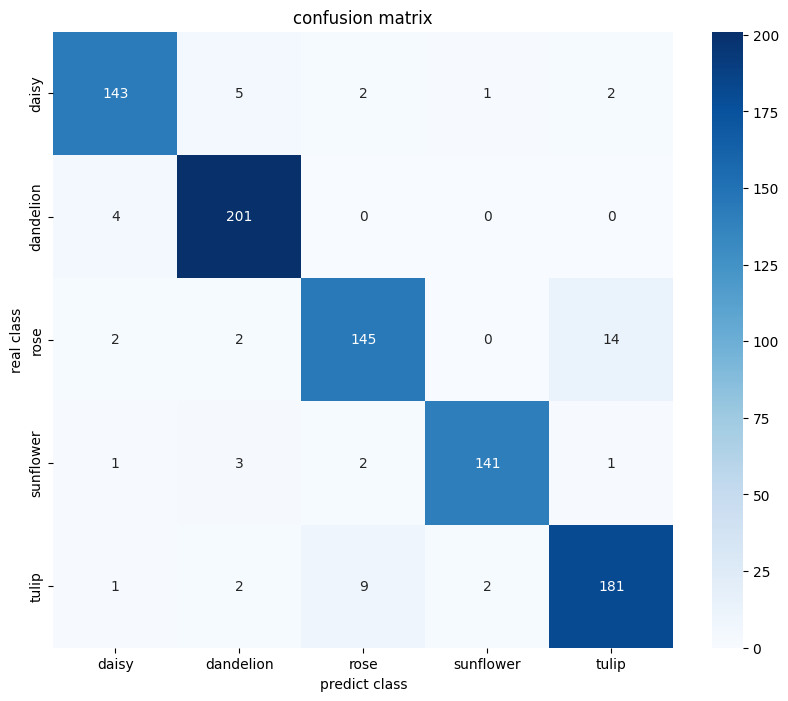

Epoch 22/25
loss: 0.2405
val accuracy: 93.87%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.94      0.98      0.96       205
        rose       0.92      0.89      0.90       163
   sunflower       0.98      0.95      0.97       148
       tulip       0.91      0.93      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



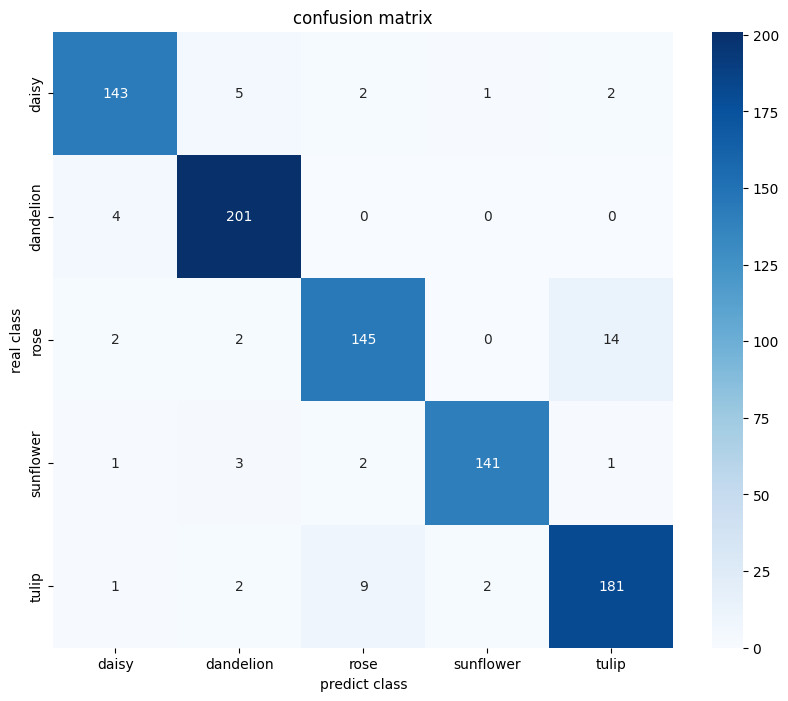

Epoch 23/25
loss: 0.2335
val accuracy: 93.87%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.94      0.98      0.96       205
        rose       0.92      0.89      0.90       163
   sunflower       0.98      0.95      0.97       148
       tulip       0.91      0.93      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



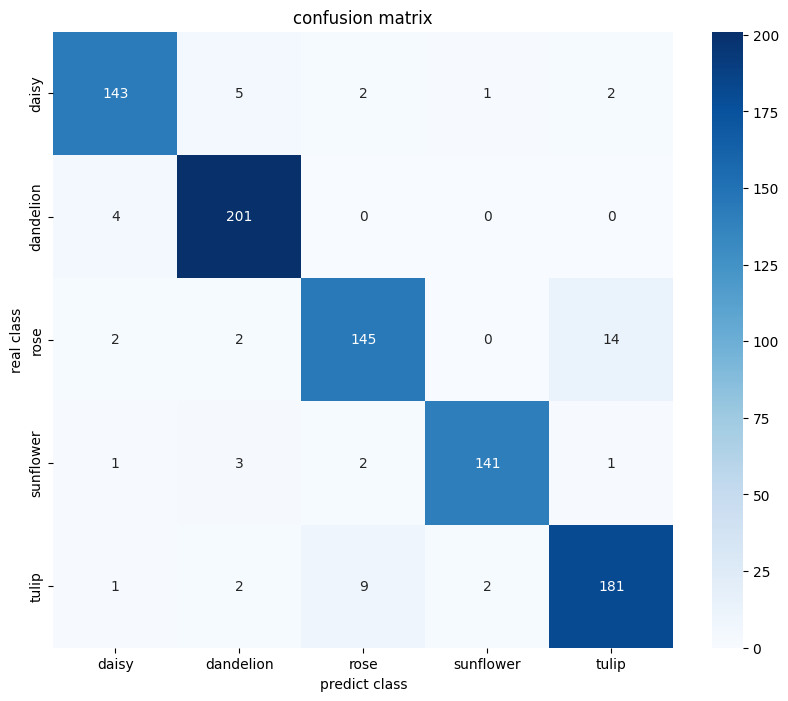

Epoch 24/25
loss: 0.2348
val accuracy: 93.87%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.94      0.98      0.96       205
        rose       0.92      0.89      0.90       163
   sunflower       0.98      0.95      0.97       148
       tulip       0.91      0.93      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



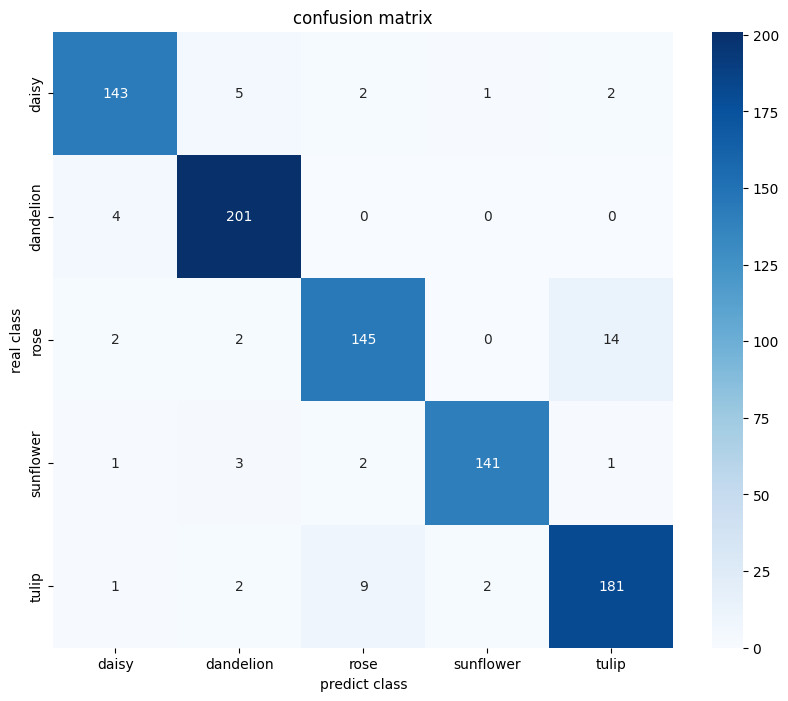

Epoch 25/25
loss: 0.2266
val accuracy: 93.87%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.94      0.98      0.96       205
        rose       0.92      0.89      0.90       163
   sunflower       0.98      0.95      0.97       148
       tulip       0.91      0.93      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



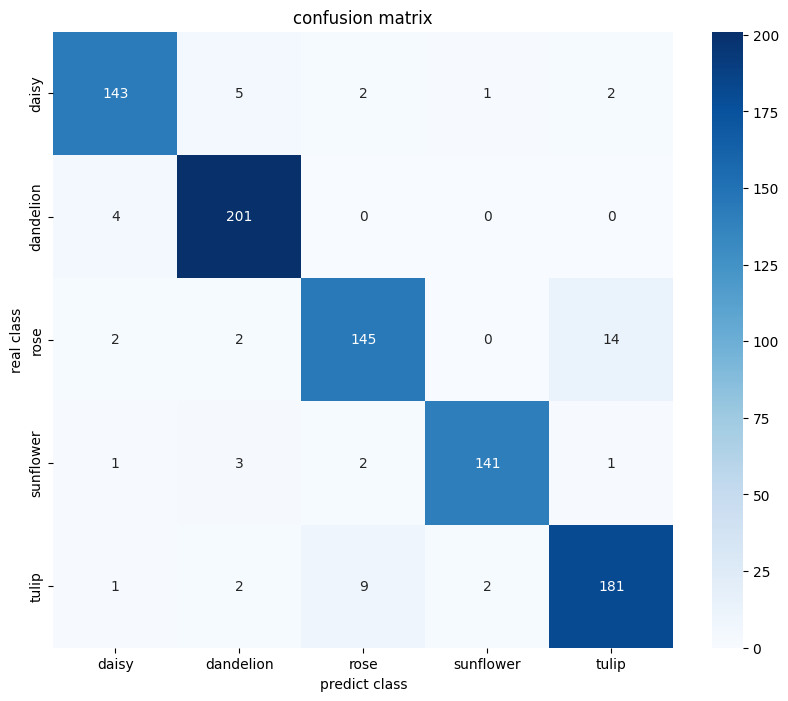

In [16]:
# define loss function:CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# define optimizer:Adam
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# learning rate and num_epochs
num_epochs = 25
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)


progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward propogation
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)

        # backward propogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        epoch_loss += loss.item()
        progress_bar.update(1)
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"loss: {avg_epoch_loss:.4f}")

    # val
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).logits
            preds = torch.argmax(outputs, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # get accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"val accuracy: {accuracy * 100:.2f}%")

    # get classification_report
    print('classification_report：')
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('predict class')
    plt.ylabel('real class')
    plt.title('confusion matrix')
    plt.show()

    #
    model.train()


# Fine tunning

unfreeze 2 layers。


  0%|          | 0/1080 [00:00<?, ?it/s]

fine tunning Epoch 1/10
loss: 0.2277
val accuracy: 93.98%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.95      0.98      0.97       205
        rose       0.91      0.89      0.90       163
   sunflower       0.99      0.95      0.97       148
       tulip       0.91      0.93      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



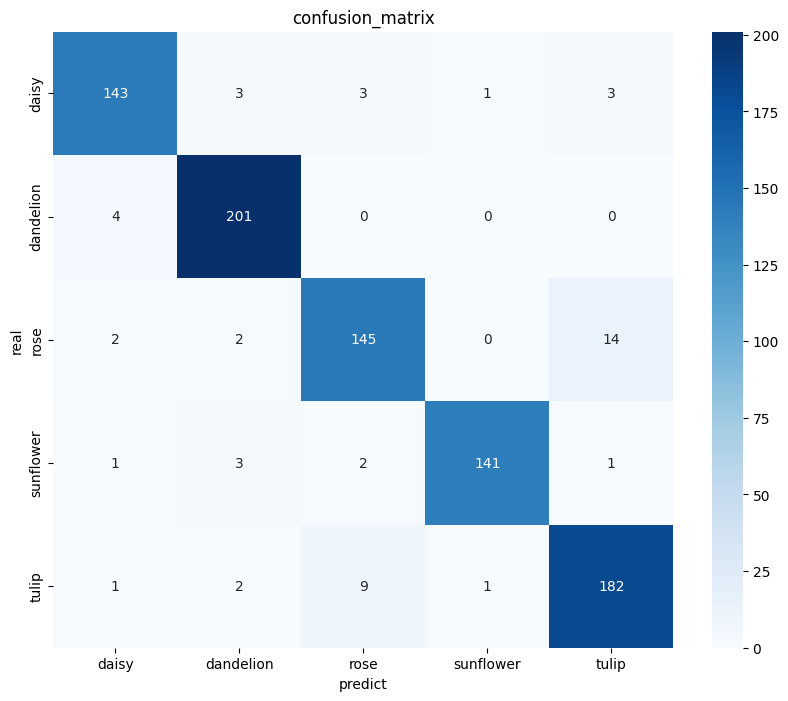

fine tunning Epoch 2/10
loss: 0.2021
val accuracy: 93.87%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.96      0.98      0.97       205
        rose       0.91      0.88      0.90       163
   sunflower       0.99      0.95      0.97       148
       tulip       0.90      0.93      0.91       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



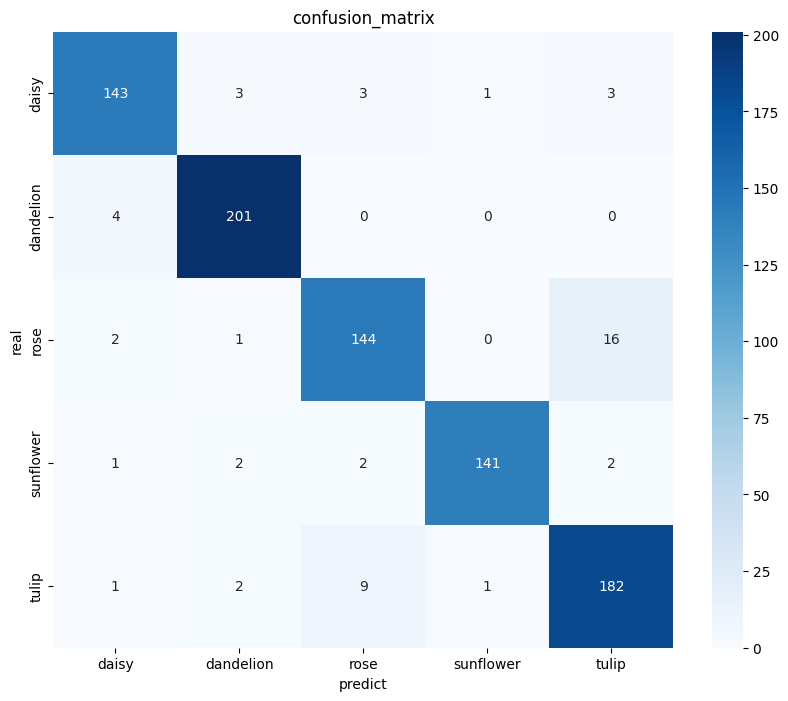

fine tunning Epoch 3/10
loss: 0.2071
val accuracy: 94.21%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.95      0.98      0.96       205
        rose       0.92      0.90      0.91       163
   sunflower       0.99      0.95      0.97       148
       tulip       0.92      0.94      0.93       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



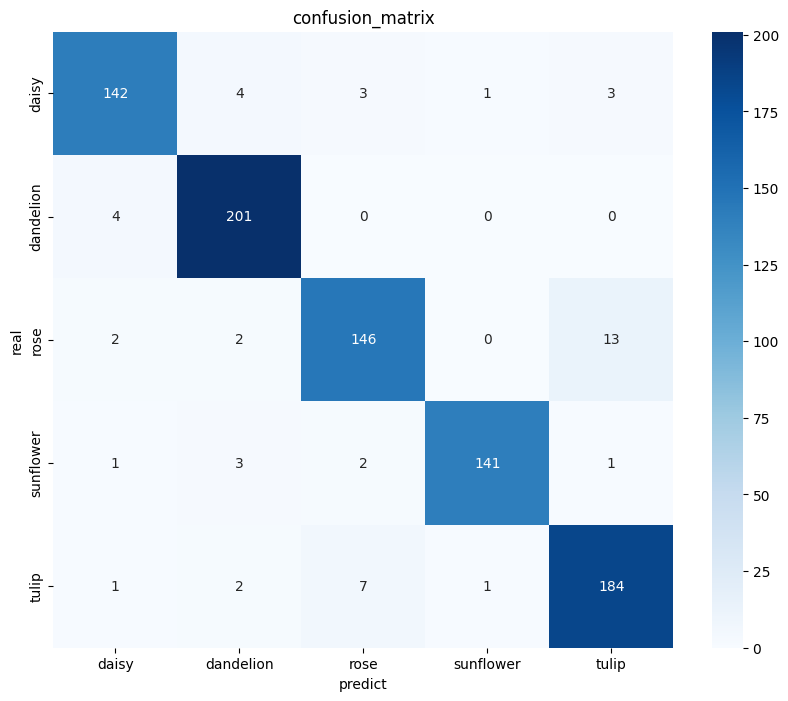

fine tunning Epoch 4/10
loss: 0.1940
val accuracy: 94.10%
classification_report：
              precision    recall  f1-score   support

       daisy       0.94      0.93      0.93       153
   dandelion       0.96      0.98      0.97       205
        rose       0.92      0.90      0.91       163
   sunflower       0.99      0.95      0.97       148
       tulip       0.91      0.94      0.92       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



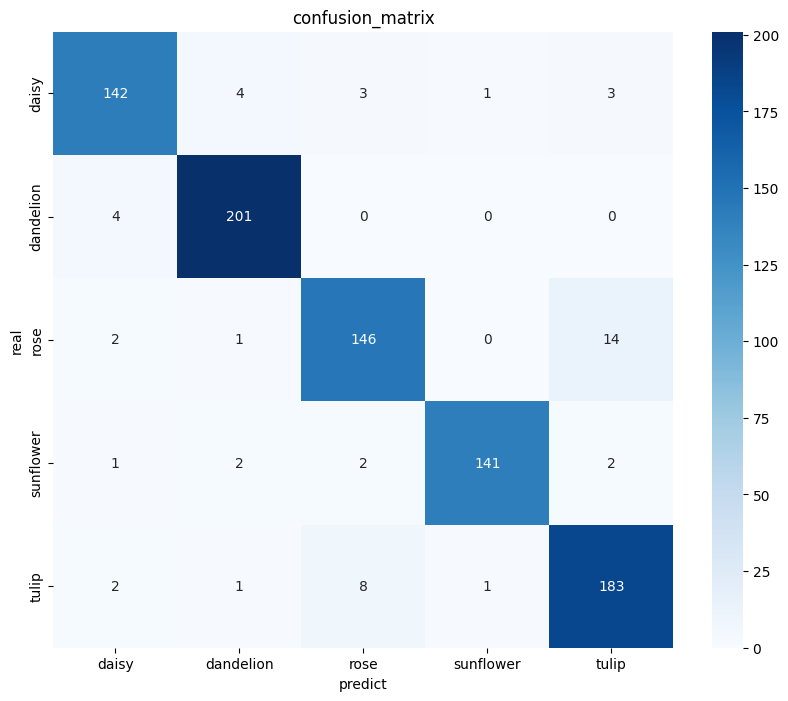

fine tunning Epoch 5/10
loss: 0.1938
val accuracy: 94.33%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.96      0.99      0.97       205
        rose       0.92      0.90      0.91       163
   sunflower       0.99      0.95      0.97       148
       tulip       0.91      0.94      0.93       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



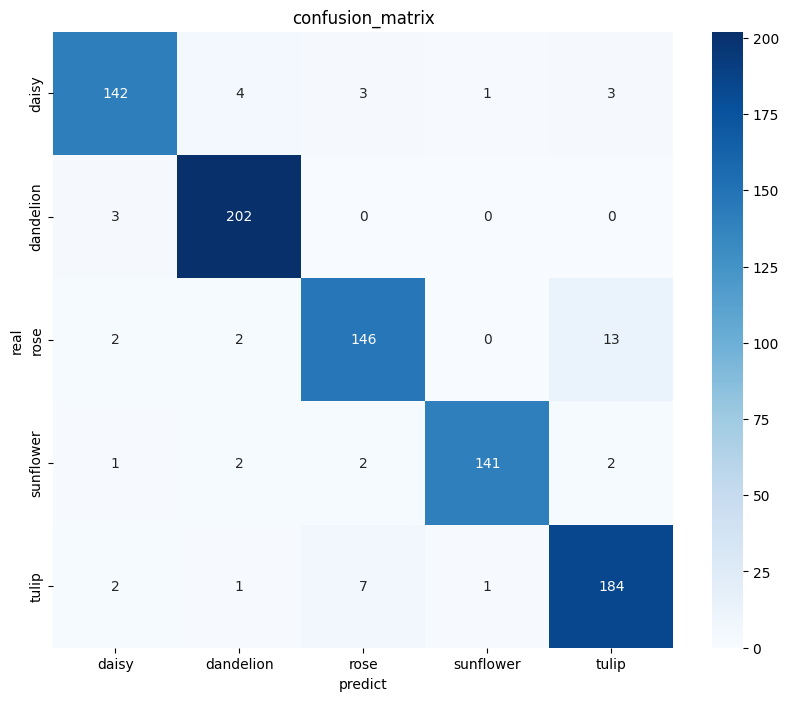

fine tunning Epoch 6/10
loss: 0.1902
val accuracy: 94.21%
classification_report：
              precision    recall  f1-score   support

       daisy       0.94      0.93      0.93       153
   dandelion       0.96      0.98      0.97       205
        rose       0.93      0.89      0.91       163
   sunflower       0.99      0.95      0.97       148
       tulip       0.90      0.95      0.93       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



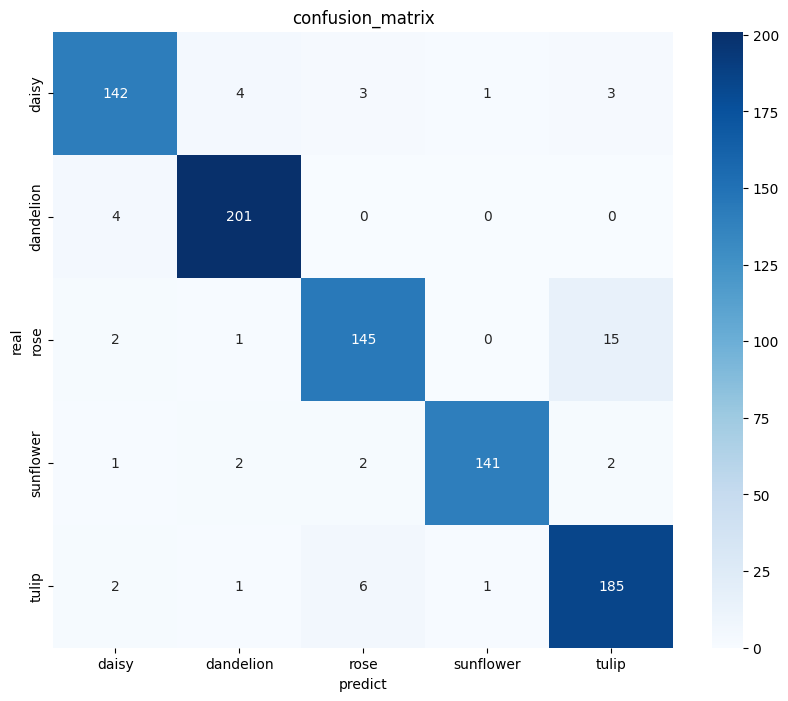

fine tunning Epoch 7/10
loss: 0.1774
val accuracy: 94.21%
classification_report：
              precision    recall  f1-score   support

       daisy       0.94      0.93      0.93       153
   dandelion       0.96      0.98      0.97       205
        rose       0.93      0.89      0.91       163
   sunflower       0.99      0.95      0.97       148
       tulip       0.90      0.95      0.93       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



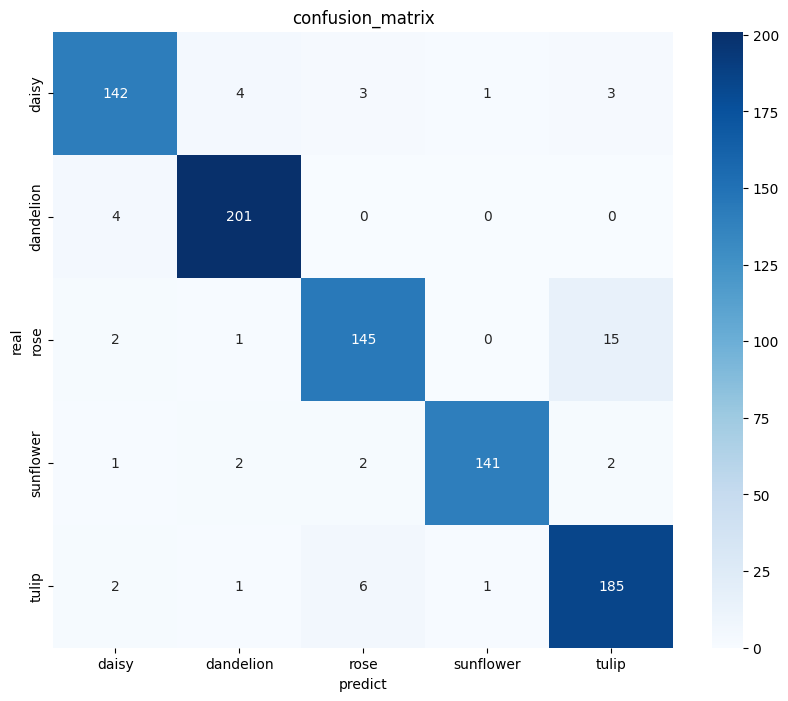

fine tunning Epoch 8/10
loss: 0.1838
val accuracy: 94.21%
classification_report：
              precision    recall  f1-score   support

       daisy       0.94      0.93      0.93       153
   dandelion       0.96      0.98      0.97       205
        rose       0.93      0.89      0.91       163
   sunflower       0.99      0.95      0.97       148
       tulip       0.90      0.95      0.93       195

    accuracy                           0.94       864
   macro avg       0.94      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



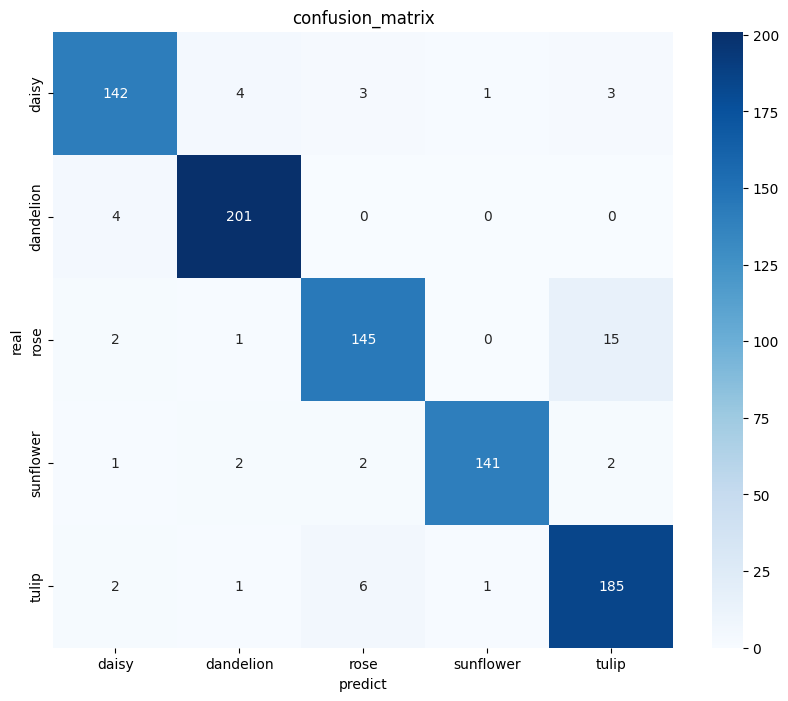

fine tunning Epoch 9/10
loss: 0.1819
val accuracy: 94.33%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.95      0.99      0.97       205
        rose       0.92      0.90      0.91       163
   sunflower       0.99      0.95      0.97       148
       tulip       0.91      0.94      0.93       195

    accuracy                           0.94       864
   macro avg       0.95      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



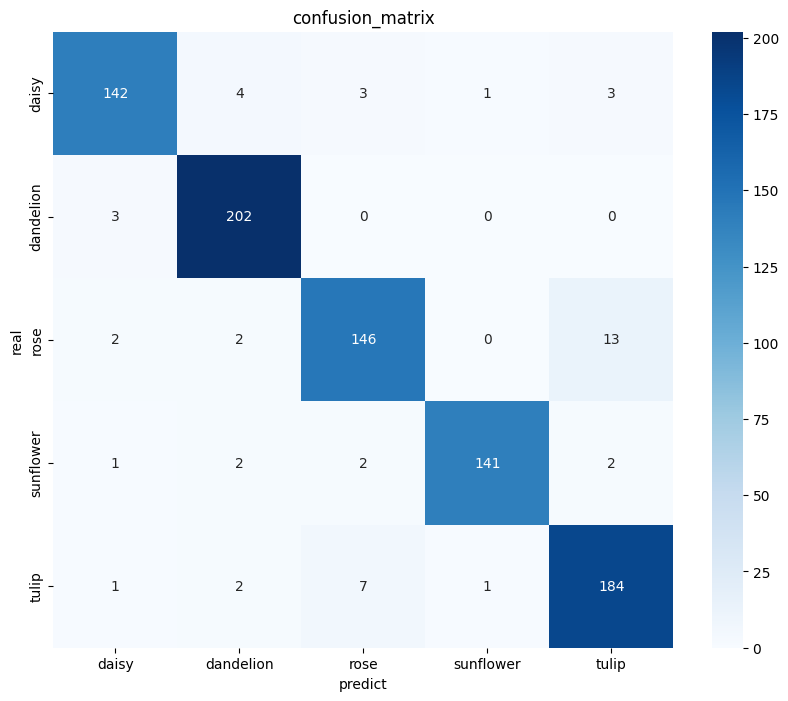

fine tunning Epoch 10/10
loss: 0.1793
val accuracy: 94.33%
classification_report：
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94       153
   dandelion       0.95      0.99      0.97       205
        rose       0.93      0.89      0.91       163
   sunflower       0.99      0.95      0.97       148
       tulip       0.91      0.95      0.93       195

    accuracy                           0.94       864
   macro avg       0.95      0.94      0.94       864
weighted avg       0.94      0.94      0.94       864



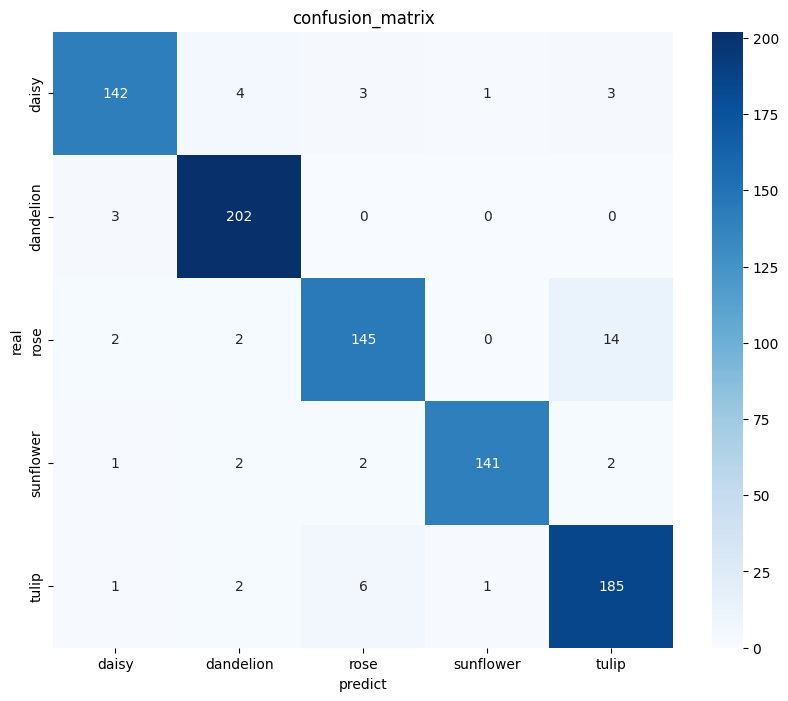

In [17]:
#train last 2 layers of vit pretrain model
num_unfreeze_layers = 2
all_layers = list(model.vit.encoder.layer)

for layer in all_layers[-num_unfreeze_layers:]:
    for param in layer.parameters():
        param.requires_grad = True

print(f"unfreeze {num_unfreeze_layers} layers。")

# . get a new learning rate for fine tunning
optimizer = torch.optim.AdamW([
    {'params': model.vit.encoder.layer[-num_unfreeze_layers:].parameters(), 'lr': 1e-5},  #
    {'params': model.classifier.parameters(), 'lr': 1e-4}  #
], lr=1e-5)

# get a new learning rate for fine tunning
num_finetune_epochs = 10
num_finetune_steps = num_finetune_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_finetune_steps
)

#  loop
progress_bar = tqdm(range(num_finetune_steps))

model.train()
for epoch in range(num_finetune_epochs):
    print(f"fine tunning Epoch {epoch + 1}/{num_finetune_epochs}")
    epoch_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)

        # back ward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        epoch_loss += loss.item()
        progress_bar.update(1)
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"loss: {avg_epoch_loss:.4f}")

    # val
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).logits
            preds = torch.argmax(outputs, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"val accuracy: {accuracy * 100:.2f}%")

    # classification_report
    print('classification_report：')
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # confusion_matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('predict')
    plt.ylabel('real')
    plt.title('confusion_matrix')
    plt.show()

    #
    model.train()

# visualize_all_single_attention_head

In [18]:
def visualize_single_attention_head(
    model,
    image_tensor,
    class_names,
    device,
    transform,
    layer_index=-1,
    head_index=0,
    IMG_SIZE=224
):
    """
    Visualize the attention map for a specific head.

    Args:
        model (torch.nn.Module): A trained ViT model.
        image_tensor (torch.Tensor): The unnormalized image tensor.
        class_names (list): A list of class names.
        device (torch.device): Computation device (CPU or GPU).
        transform (torchvision.transforms.Compose): Image preprocessing transforms.
        layer_index (int): Index of the Transformer layer to visualize (default: last layer).
        head_index (int): The attention head index (default: 0).
        IMG_SIZE (int): Image size (default: 224).
    """
    model.eval()

    # Convert the tensor to a PIL image
    image_pil = transforms.ToPILImage()(image_tensor.cpu())

    # Add batch dimension and move to device
    input_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        attentions = outputs.attentions[layer_index]  # (1, num_heads, num_tokens, num_tokens)

    # Extract the specified layer and head
    target_layer_attentions = attentions[0]  # shape: (num_heads, num_tokens, num_tokens)
    cls_attention = target_layer_attentions[head_index, 0, 1:]  # shape: (num_patches,)

    # Convert to numpy
    cls_attention_mean = cls_attention.cpu().numpy()

    # Calculate the grid size
    patch_size = 16  # For 'google/vit-base-patch16-224', patch_size is 16
    grid_size = IMG_SIZE // patch_size  # 224/16 = 14

    # Reshape attention to a grid
    try:
        cls_attention_grid = cls_attention_mean.reshape(grid_size, grid_size)
    except ValueError:
        print(f"Cannot reshape {cls_attention_mean.shape[0]} patches into a {grid_size}x{grid_size} grid.")
        return

    # Normalize attention values to [0, 1]
    cls_attention_grid = (
        (cls_attention_grid - cls_attention_grid.min())
        / (cls_attention_grid.max() - cls_attention_grid.min())
    )

    # Resize the grid to match the image size
    attention_map = Image.fromarray(
        np.uint8(cls_attention_grid * 255)
    ).resize((IMG_SIZE, IMG_SIZE), resample=Image.BILINEAR)
    attention_map = np.array(attention_map) / 255.0

    # Overlay attention map on the image
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image_pil.resize((IMG_SIZE, IMG_SIZE)))
    ax.imshow(
        attention_map,
        cmap='jet',
        alpha=0.5,
        extent=(0, IMG_SIZE, IMG_SIZE, 0)
    )
    ax.axis('off')
    ax.set_title(f"Head {head_index} Attention Map", fontsize=16)
    plt.show()


Random index: 628, label id: 1, class: dandelion
Transformed image tensor shape: torch.Size([3, 224, 224])
img_path: /root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/dandelion/19622465055_2a62ebd504_m.jpg
original_label: 1  ->  dandelion


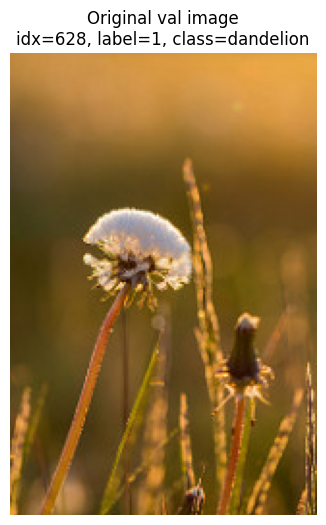

Randomly chosen index: 628, label id: 1, class: dandelion
Image tensor shape: torch.Size([3, 224, 224])


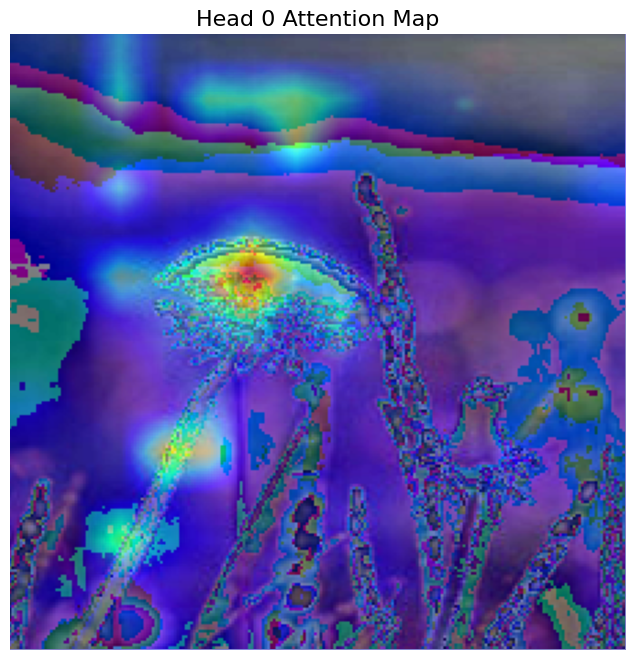

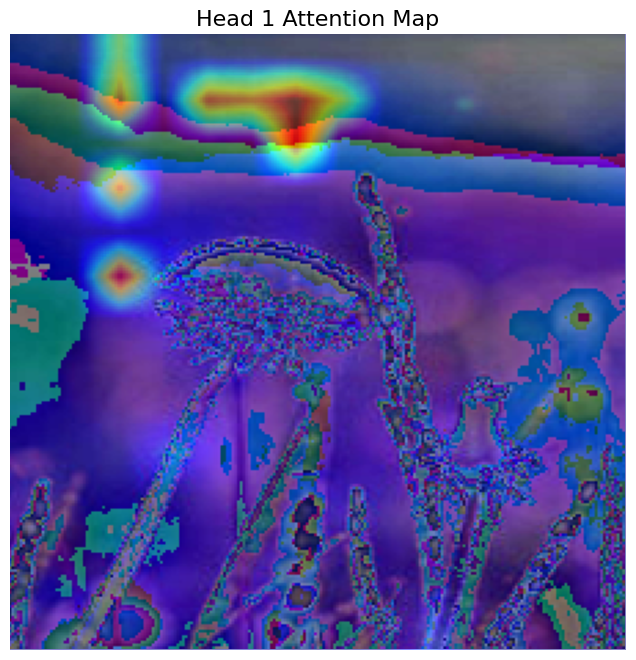

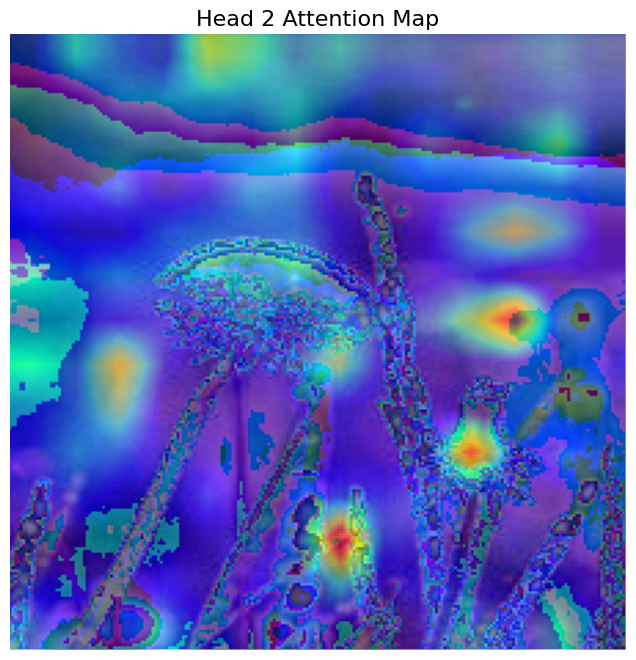

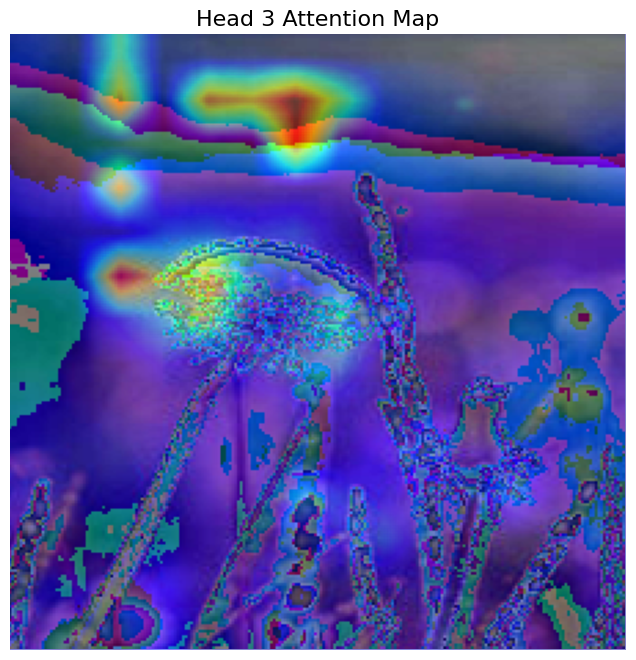

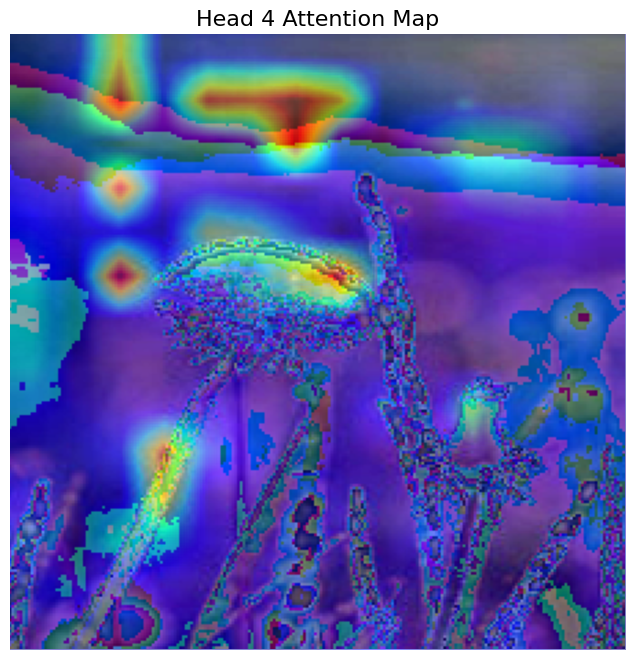

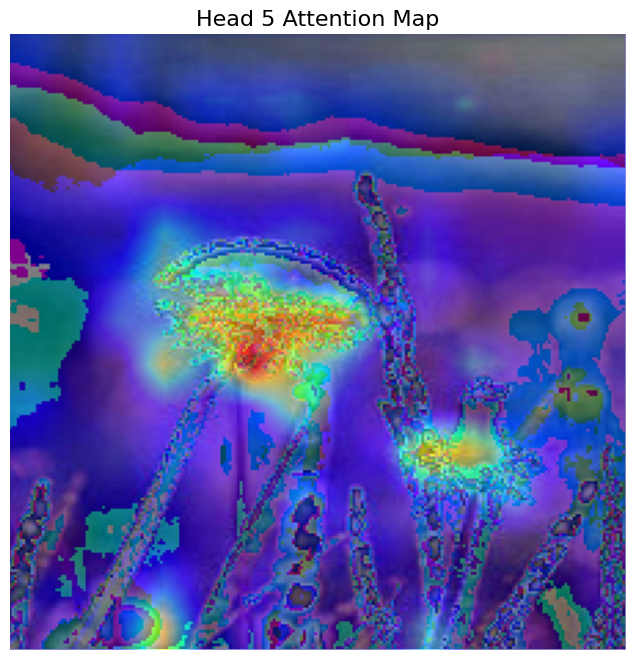

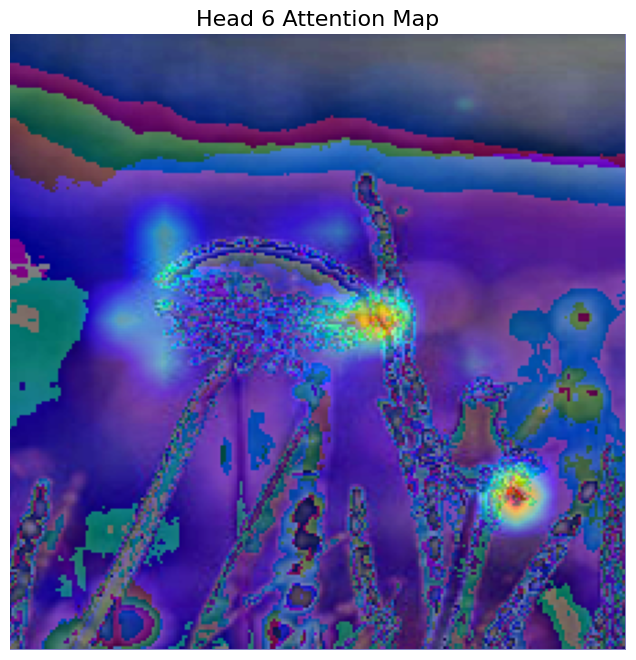

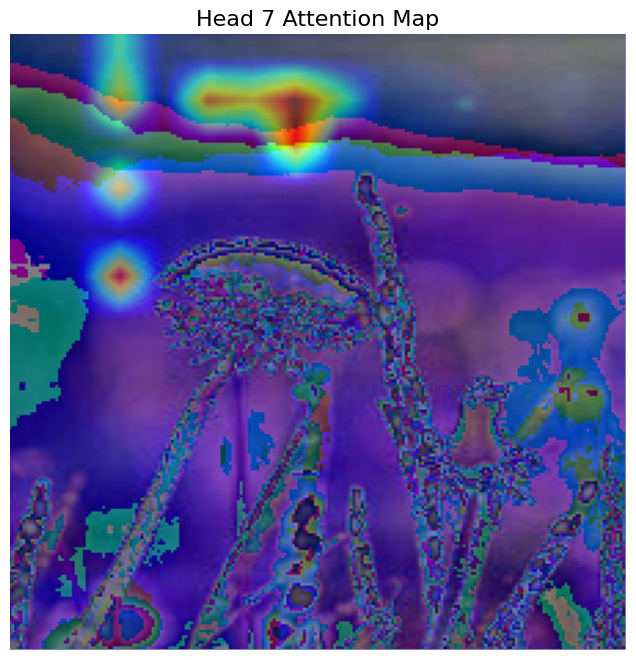

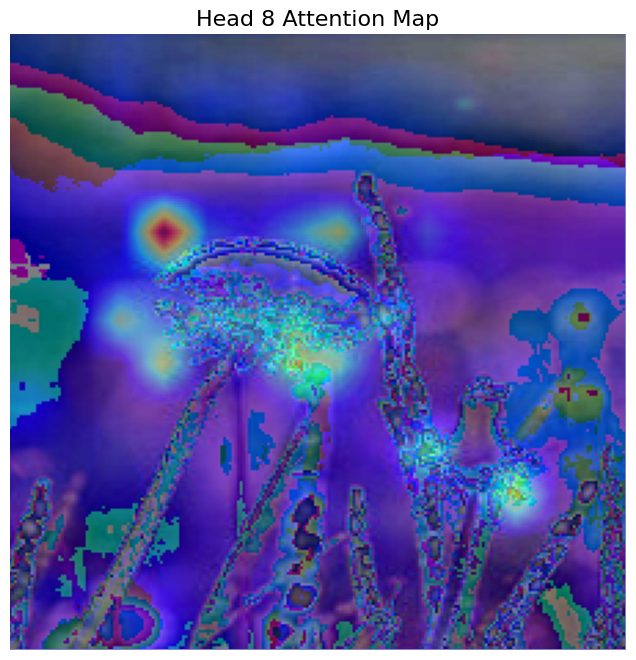

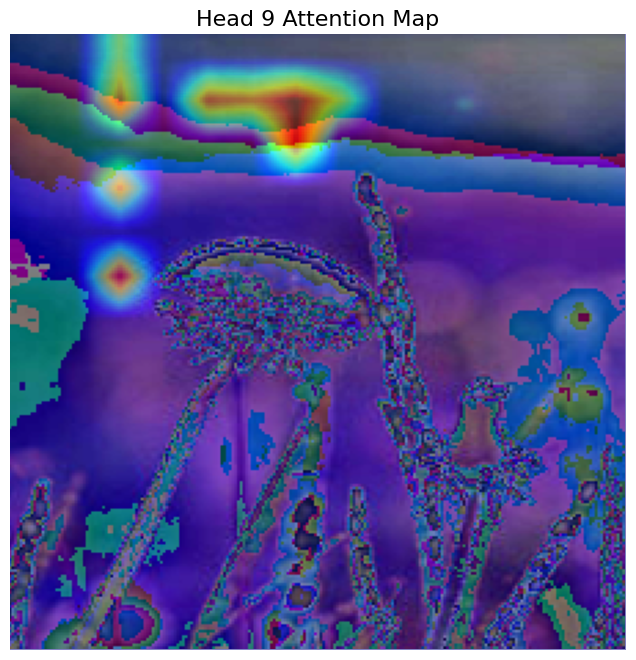

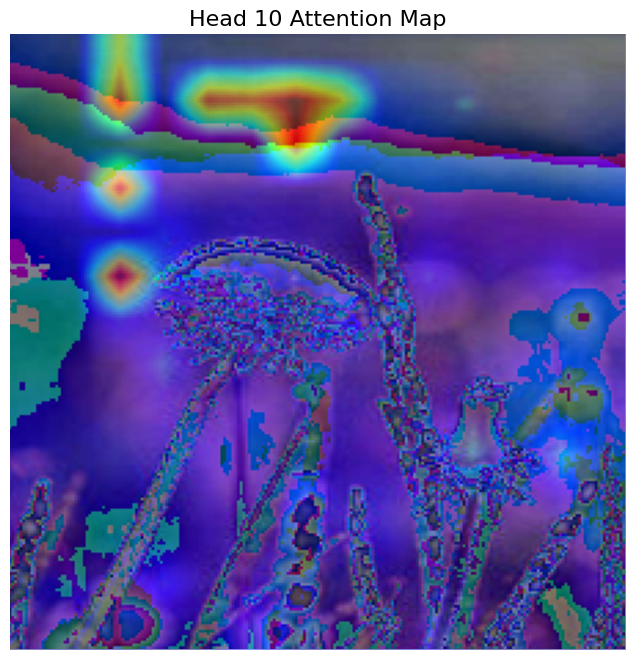

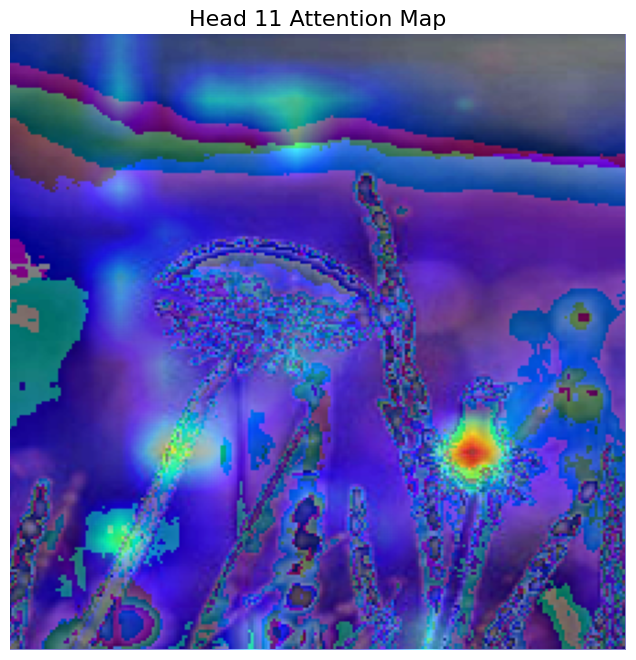

In [44]:
import random
import torch



# 1) ramdom sample
random_index = random.randint(0, len(val_dataset) - 1)

# original picture
image_tensor, label = val_dataset[random_index]
print(f"Random index: {random_index}, label id: {label}, class: {class_names[label]}")
print("Transformed image tensor shape:", image_tensor.shape)

# 3)、
original_idx = val_dataset.indices[random_index]

# 4) 、
img_path, original_label = val_dataset.dataset.samples[original_idx]

print("img_path:", img_path)
print("original_label:", original_label, " -> ", class_names[original_label])

# 5) 、
raw_image = Image.open(img_path).convert("RGB")

# 6)show
plt.figure(figsize=(6, 6))
plt.imshow(raw_image)
plt.title(f"Original val image\nidx={random_index}, label={original_label}, class={class_names[original_label]}")
plt.axis("off")
plt.show()


image_tensor, label = val_dataset[random_index]
print(f"Randomly chosen index: {random_index}, label id: {label}, class: {class_names[label]}")
print("Image tensor shape:", image_tensor.shape)  # e.g. (3, 224, 224)




# visualize heatmap
#
layer_idx = -1  # layer
num_heads = 12  # heads

for head_idx in range(num_heads):
    visualize_single_attention_head(
        model=model,
        image_tensor=image_tensor,
        class_names=class_names,
        device=device,
        transform=val_transform,
        layer_index=layer_idx,
        head_index=head_idx,
        IMG_SIZE=224
    )
